In [1]:
import time
ini_tempo=time.time()

import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier as RFC_
from sklearn.ensemble import RandomForestRegressor as RFR_
from sklearn import metrics


rept=1
quanti_col='KG_LIQUIDO'

md_c=None
md_r=None
y_active=10
comp_min=5
comp_max=None # Esta com problema se fñao for None

imp_fert=pd.read_csv('~/git/BD/temp/imp_fert_quanti.csv')

In [2]:
# Filtra deixando passar o mês de maior quantidade
g=imp_fert.groupby('CO_MES').KG_LIQUIDO.sum().sort_values(ascending=False)
#print(g)
g=g.index[1]
imp_fert=imp_fert[imp_fert.CO_MES==g]

In [3]:
# Seleciona UF e nick
uf_list=['BA']
nick_list_list=[['UREIA_k','MOP_k','MAP_k','SAM_k'],['UREIA_k']]

s=pd.DataFrame()

# Inicia loop sobre as listas de nick
for nick_list in nick_list_list:

    print('nick_list:',nick_list)
    
    # Filtra nick listados
    imp_fert_t=imp_fert[(imp_fert.SG_UF_NCM.astype(str).isin(uf_list))&(imp_fert.nick.astype(str).isin(nick_list))]
    
    # Cria date
    imp_fert_t['date']=pd.to_datetime(imp_fert_t.CO_ANO.astype(str)+'/'+imp_fert_t.CO_MES.astype(str)+'/1')
    
    u=pd.DataFrame()
    # Inicia loop sobre as datas
    for date_pred in imp_fert_t.date.unique().tolist():
            
        imp_fert_t2=imp_fert_t[imp_fert_t.date<=date_pred]

        # Informa os tipo das colunas categóricas
        imp_fert_t2[['CO_MES','nick','SG_UF_NCM','CO_PAIS','CO_URF']]=\
        imp_fert_t2[['CO_MES','nick','SG_UF_NCM','CO_PAIS','CO_URF']].astype('category')
    
        #################### Filtra categorias ativas ####################
        %run '~/git/BD/Comexstat/function/filtra_categorias_ativas.ipynb'
        imp_fert_t2=filtra_categorias_ativas(imp_fert_t2)
        ##################################################################
       
        ############## preve(comex_df_NCM,comp_min,comp_max,md_c,md_r,quanti_col)####################################################
        %run '~/git/BD/Comexstat/function/preve.ipynb'
        score=preve(imp_fert_t2,nick_list,date_pred,comp_min,comp_max,md_c,md_r,quanti_col)
        #############################################################################################################################
        
        u=pd.concat([u,score])
        
    s=pd.concat([s,u])


nick_list: ['UREIA_k', 'MOP_k', 'MAP_k', 'SAM_k']
nick_list: ['UREIA_k']


Text(0.5, 1.01, 'testemunha')

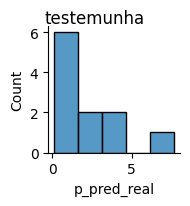

In [4]:
s[['date']]=s[['date']].astype('datetime64[ns]')

s=s[s.nick=='UREIA_k']

s.loc[s.nick_list==s.nick_list.unique()[0],'tipo']='tratamento'

s.loc[s.nick_list==s.nick_list.unique()[1],'tipo']='testemunha'

sg=round(s.groupby(by=['tipo','date_pred','rept'])[['KG_LIQUIDO','kg_pred']].mean()/10**6).reset_index().sort_values('date_pred')

sg=sg.assign(p_pred_real=round(sg.kg_pred/sg.KG_LIQUIDO,2))

t='testemunha'
sns.displot(data=sg[sg.tipo==t],x='p_pred_real',height=2,bins=5).fig.suptitle(t,y=1.01)

Text(0.5, 1.01, 'tratamento')

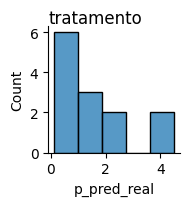

In [5]:
t='tratamento'
sns.displot(data=sg[sg.tipo==t],x='p_pred_real',height=2,bins=5).fig.suptitle(t,y=1.01)

In [6]:
sg.columns

Index(['tipo', 'date_pred', 'rept', 'KG_LIQUIDO', 'kg_pred', 'p_pred_real'], dtype='object')

In [7]:
a=sg[sg.tipo=='testemunha'].rename(columns={'p_pred_real':'testemunha'}).reset_index(drop=True).drop(columns='tipo')
b=sg[sg.tipo=='tratamento'].rename(columns={'p_pred_real':'tratamento'}).reset_index(drop=True).drop(columns=['tipo','kg_pred'])

sg1=a.merge(b,how='outer')

sg1=sg1[['tratamento','testemunha']].dropna()

sg1=sg1.assign(dif=sg1[sg1.columns[0]]-sg1[sg1.columns[1]])

sg1.head()

,tratamento,testemunha,dif
3,2.27,2.00,0.27
11,4.00,7.67,-3.67
12,1.50,3.50,-2.00
13,2.60,1.60,1.00
15,0.50,0.46,0.04


In [8]:
sg1.mean()

tratamento    1.774545
testemunha    2.150000
dif          -0.375455
dtype: float64

In [9]:
sg1.std()

tratamento    1.439273
testemunha    2.151004
dif           1.355790
dtype: float64

In [11]:
mean_dif=sg1.dif.mean()
std_dif=sg1.dif.std()
mean_dif,std_dif

(-0.37545454545454554, 1.3557902760852332)

In [12]:
# h1 maior que zero
z_score=(0-mean_dif)/std_dif
z_score

0.2769267135759736

In [13]:
from scipy.stats import norm
p=round(norm.cdf(z_score,loc=0,scale=1),3)
print(f"O p_value foi de {p}.")

O p_value foi de 0.609.


In [14]:
alpha=0.05
if p<=alpha:
    print(f'\n\nPelo método paramétrico, com significância de {alpha}, "reject Ho"\n\n\
    O tratamento FOI MELHOR do que a testemunha.')
else:
    print(f'\n\nPelo método paramétrico, com significância de {alpha}, "fail to reject Ho"\n\n\
    O tratamento NÃO FOI MELHOR do que a testemunha.')



Pelo método paramétrico, com significância de 0.05, "fail to reject Ho"

    O tratamento NÃO FOI MELHOR do que a testemunha.


In [15]:
beta=1-0.05
if p>=beta:
    print(f'\n\nPelo método paramétrico, com significância de {alpha}, "reject Ho"\n\n\
    O tratamento FOI PIOR do que a testemunha.')
else:
    print(f'\n\nPelo método paramétrico, com significância de {alpha}, "fail to reject Ho"\n\n\
    O tratamento NÃO FOI PIOR do que a testemunha.')



Pelo método paramétrico, com significância de 0.05, "fail to reject Ho"

    O tratamento NÃO FOI PIOR do que a testemunha.


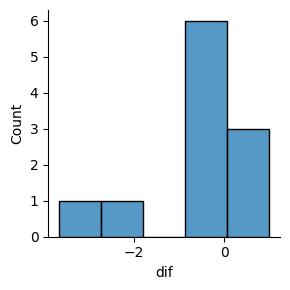

In [16]:
sns.displot(data=sg1,x='dif',height=3,bins=5)

In [ ]:
fim_tempo=time.time()
print('\n\n',round((fim_tempo-ini_tempo)/60,1),' minutos\n\n')